In [1]:
import actr
import pickle
import random
import os
import fnmatch
import sys
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import groupby
import json

ACT-R connection has been started.


### Observed Issues:
(see file "current_issues")

- Recency effect still too weak.

- Primacy effect too strong.



#### Number of words in each list i.e. list_length should be n where (n-2)%3 == 0 because 2 neutral words are added in each list.

#### The adjustable parameters in this experiment code.
    - number of agents (top of next cell)
    - experimental conditions (further below) --> multiple conditions can be set in a list of lists [[rehearsal time1, num words per list 1], [rehearsal time 2, num words per list 2], ...]
    - Number of lists (further below)
#### Adjustable parameters in ACT-R
    - :declarative-num-finsts 21 ; number of items that are kept as recently retrieved (Change it to 5) 
    - :declarative-finst-span 21 ; how long items stay in the recently-retrieved state (5,100)

In [2]:
help(actr)

Help on module actr:

NAME
    actr

CLASSES
    builtins.object
        actr
        interface
        request
    
    class actr(builtins.object)
     |  actr(host, port)
     |  
     |  Methods defined here:
     |  
     |  __init__(self, host, port)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  add_command(self, name, function, documentation='No documentation provided.', single=True, actr_name=None)
     |  
     |  evaluate(self, *params)
     |  
     |  evaluate_single(self, *params)
     |  
     |  monitor_command(self, original, monitor)
     |  
     |  remove_command(self, name)
     |  
     |  remove_command_monitor(self, original, monitor)
     |  
     |  ----------------------------------------------------------------------
     |  Data descriptors defined here:
     |  
     |  __dict__
     |      dictionary for instance variables (if defined)
     |  
     |  __weakref__
     |      list of weak references to the obje

In [3]:
### Experiment part ###

num_agents = 2 #set number of agents per condition

def __init__(iteration, rehearsal_time, list_length, list_amount=3, path="."):
    subject = ''

    current_list = ''

    recalled_words = defaultdict(list)

    rehearsed_words =  defaultdict(lambda: defaultdict(int))

    #list_amount = 3   # No of lists (100, 200, 1000, 2000 AND 5000)

    #Set below where function is actually called
    list_length = list_length   # No of words in a list
    rehearsal_time = rehearsal_time  # No of seconds for which rehearsal happens and each word is shown

    delay = 1  #delay between rehearsal and recall

    recall_time = 90

    word_lists_dict = defaultdict(list)
    
    # Ensure there are enough unique words to create the word lists
    word_dict = {"positive": ["positive" + str(i) for i in range(999)],
                 "negative": ["negative" + str(i) for i in range(999)],
                 "neutral": ["neutral" + str(i) for i in range(999)]}

    filename = f'{path}\words_{list_length}_lists_{list_amount}_rh_time_{rehearsal_time}_rec_time_{recall_time}_delay_{delay}_{iteration}.txt'
    
    results = {}

    results['x'] = {'data': [], # will be appended later in the analytics function
                          'info': "Storing range(len(word_lists_dict[0])) here"}

    results['rehearse_frequency'] = {'data': None,# will be appended later in the analytics function

                                     'info': "Storing list(rehearse_frequency.values()) here"}

    results['recall_probability'] = {'data': None, # will be appended later in the analytics function
                                        'info': "Storing list(recall_probability.values()) here"}

    results['first_recall'] = {'data': None, # will be appended later in the analytics function
                               'info': "Storing list(first_probability.values()) here"}

    with open(filename, 'w') as outfile:
        json.dump(results, outfile)

    with open(filename) as json_file:
        results = json.load(json_file)
#         #print(results)
    
    globals().update(locals())  ## Making everything public, worst code you can ever write!!

In [4]:
def add_words(i, list_length):
    '''
    Add the words to the word lists, ensures valence categories are balanced
    '''
    global word_lists_dict

    amnt_wanted = list_length #-2)/3 #not needed here because Murdock experiment # Amount of each valence wanted, minus 2 neutrals controlling for primacy
    amt_positive, amt_negative, amt_neutral, count = 0, 0, 0, 0
    while len(word_lists_dict[i]) != list_length:
        count += 1
        #print(f"...................{count,word_lists_dict[i]}")
        if count >= 9999: # IF it takes too long to create a unique list at random, start over
            word_lists_dict[i] = []
            add_words(i, list_length)
        if len(word_lists_dict[i]) == 0: # Place two neutral words at the start to control for primacy effects
            word_to_add1 = word_dict["neutral"][random.randint(0, len(word_dict["neutral"])-1)]
            word_to_add2 = word_dict["neutral"][random.randint(0, len(word_dict["neutral"])-1)]
            if word_to_add1 not in word_lists_dict[i] and word_to_add2 not in word_lists_dict[i] and word_to_add1 != word_to_add2:
                word_lists_dict[i].append(word_to_add1)
                word_lists_dict[i].append(word_to_add2)
            else:
                continue # skip this loop iteration                   
        else: 
            random_valence = random.choice(["positive", "negative", "neutral"])
            word_to_add = word_dict[random_valence][random.randint(0, len(word_dict[random_valence])-1)]
            if word_to_add not in word_lists_dict[i] and word_lists_dict[i][-1] not in word_dict[random_valence] and \
               amt_positive <= amnt_wanted and amt_negative <= amnt_wanted and amt_neutral <= amnt_wanted:
                if random_valence == "positive" and amt_positive < amnt_wanted:
                    amt_positive += 1
                elif random_valence == "negative" and amt_negative < amnt_wanted:
                    amt_negative +=1
                elif random_valence == "neutral" and amt_neutral < amnt_wanted:
                    amt_neutral +=1
                else:
                    continue # skip this loop iteration
                word_lists_dict[i].append(word_to_add)

def create_lists(list_amount=3, list_length=2):
    '''
    Create the wordlists used during the free recall tasks 
    '''  
    global word_lists_dict 

    for i in range(list_amount):
        print(f'List {i+1}/{list_amount} created!', end="\r")
        add_words(i, list_length)

    # Save the dictionary to a .pickle file, so we do not have to create the word lists everytime we run the model                    
    file = open(f"word_lists/word_lists_dict_{list_length}_{list_amount}.pickle","wb")
    pickle.dump(word_lists_dict, file)
    file.close()
    return word_lists_dict

# Check if the word lists already exist, else create new word lists
def check_and_create_lists():
    global word_lists_dict
    try:
        file = open(f"word_lists/word_lists_dict_{list_length}_{list_amount}.pickle","rb")
        #file = open(f"word_lists_dict_100_items_only.pickle","rb")
        word_lists_dict = pickle.load(file)  
        file.close()
        print("\nSuccesfully loaded the word lists!\n")
    except FileNotFoundError:
        print("\nCreating word lists!\n")
        #amount_to_create = list_amount                              
        word_lists_dict = create_lists(list_amount,list_length)

def display_word_lists():
    '''
    Display the word lists loaded/created
    '''
    for key, value in word_lists_dict.items():
        print(f'List {key}:\n {value}\n')

def close_exp_window():
    '''
    Close opened ACT-R window
    '''
    return actr.current_connection.evaluate_single("close-exp-window")

def prepare_for_recall(): 
    '''
    Disable rehearsing productions, and clearing buffer contents to start the recalling phase 
    '''
    disable_list = ["rehearse-first", "rehearse-second", "rehearse-third", "rehearse-fourth", 
                    "retrieve-it", "rehearse-first-default", "rehearse-second-default",
                    "rehearse-third-default", "rehearse-fourth-default", "rehearse-it"
                   "skip-first, skip-second", "skip-third", "skip-fourth", "forget-word-1",
                   "forget-word-2", "forget-word-3", "forget-word-4"]
    
    for prod in disable_list:
        actr.pdisable(prod)
    actr.run(delay, False) 
    for buff in ["imaginal", "retrieval", "production"]:
        actr.clear_buffer(buff)  

def setup_dm(word_list):
    '''
    Add words to declarative memory, since it can be assumed the test subjects know the English language already
    '''
    #print("\n\n############################################# Inside setup_dm i.e. Declarative Memory")
     
    colour_conversion = {'pos': 'GREEN', 'neg': 'RED', 'neu': 'BLACK'}
    for idx, word in enumerate(word_list):
        valence = ''.join([char for char in word if not char.isdigit()])[:3]
        actr.add_dm(('item'+str(idx), 'isa', 'memory', 'word', "'"+word+"'", 'valence', colour_conversion[valence]))
#         if idx == 0:
#             print("\n Emaple of a chunk added in Declarative Memory is \n")
#             print('item'+str(idx), 'isa', 'memory', 'word', "'"+word+"'", 'valence', colour_conversion[valence],"\n")
        

def setup_experiment(human=True):
    '''
    Load the correct ACT-R model, and create a window to display the words
    '''
#     print("\n\n############################################# Inside setup_experiment")
#     print(f'\nSubject = {subject}\n')  

    loaded = None
    if subject == "controls":
        loaded = actr.load_act_r_model(r"C:\Users\cleme\Documents\Education\RUG\First-Year_Research\My_Project\Model\models\general_free_recall_model_v2.lisp")
        #loaded = actr.load_act_r_model(r"C:\Users\cleme\Documents\Education\RUG\First-Year_Research\My_Project\Model\models\csm_free_recall_model.lisp")
    elif subject == "depressed":
        loaded = actr.load_act_r_model(r"")

    #print("\n\n############################################# Inside setup_experiment")
    #print(f'\nLoaded Act-r model = {loaded}\n')  

    window = actr.open_exp_window("Free Recall Experiment", width=1024, height=768, visible=human) # 15inch resolution window
    actr.install_device(window) 
    return window    

def record_words_recalled(item):
    '''
    Register which words were recalled during the experiment for a specific wordlist and strip the numbers
    '''
    valence = ''.join(char for char in item if not char.isdigit())
    item_idx = ''.join(char for char in item if char.isdigit())
    recalled_words[current_list].append((valence, item_idx))

def record_words_rehearsed(item):
    '''
    Register amount of rehearsals per word for each wordlist
    '''
    rehearsed_words[current_list][item] += 1

def create_lplot(idx, xlabel, ylabel, x, y, xticks_len, filename, ytick_range=None, show=False):
    '''
    Create line plot using matplotlib
    '''
    plt.figure(idx)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, y)
    plt.xticks(np.arange(0, xticks_len, 1)) 
    plt.yticks(ytick_range)
    #plt.savefig("images/"+subject+"_"+filename, bbox_inches='tight')
    if show:
        plt.show()    

        
def create_result_dict():
    '''
    Use a module-level function, instead of lambda function, to enable pickling it
    '''
    return defaultdict(int)

## Creating different pickle files to store results from multiple hyper-parameter values.


def analysis(wlist_amount, show_plots=False):
    '''
    Review results of the recall experiment
    '''
    global results
    result_dict = defaultdict(create_result_dict) # instead of defaultdict(lambda: defaultdict(int))
    first_recall = defaultdict(int)
    recall_probability = defaultdict(int)
    rehearse_frequency = defaultdict(int)
    transitions_amnt = 0
    thought_train_len = []

    for key, val in recalled_words.items():
        thought_train_len.extend([(k, sum(1 for _ in count)) for k, count in groupby([val[0] for val in val[2:]])])
        for idx, (retrieved_word, item_num) in enumerate(val[2:]):
            if idx != 0:
                if retrieved_word != val[2:][idx-1][0]:
                    transitions_amnt += 1/wlist_amount # average over word lists

    print(f'Avg. Amount of recall transitions = {int(transitions_amnt)}')
    neg_thought_train_len = 0
    neg_divider = 0.0001
    for x in thought_train_len:
        if x[0] == 'negative':
            neg_divider += 1
            neg_thought_train_len += x[1]
    print(f'Avg. Negative Thought train length = {round(neg_thought_train_len/neg_divider, 3)}')            

    for list_num, wlist in word_lists_dict.items():
        if list_num < wlist_amount:
            for key, val in recalled_words.items():
                if key==list_num:
                    first_recall[wlist.index(''.join(val[0]))] += 1   
                    for idx, word in enumerate(wlist):
                        first_recall[idx] += 0
                        if ((''.join(char for char in word if not char.isdigit()), 
                             ''.join(char for char in word if char.isdigit()))) in val:
                            recall_probability[idx] += 1
                        else:
                            recall_probability[idx] += 0                            
                for retrieved_word, item_num in val[2:4]:
                    result_dict["pstart"][retrieved_word] += 1  
                for retrieved_word, item_num in val[4:-2]:
                    result_dict["pstay"][retrieved_word] += 1
                for retrieved_word, item_num in val[-2:]:
                    result_dict["pstop"][retrieved_word] += 1                                                        
            for key, val in rehearsed_words.items():
                if key==list_num:
                    for idx, word in enumerate(wlist):
                        rehearse_frequency[idx] += rehearsed_words[key][word]
    
    for key, val in first_recall.items():
        first_recall[key] = val/wlist_amount

    for key, val in recall_probability.items():
        recall_probability[key] = val/wlist_amount

    for key, val in rehearse_frequency.items():
        rehearse_frequency[key] = val/wlist_amount      
        
    

    xticks_len = len(word_lists_dict[0])
    
    
    #results['x']['data'].append(range(len(word_lists_dict[0])))
    #results['xticks_len']['data'].append(len(word_lists_dict[0]) )
    results['rehearse_frequency']['data'] = list(rehearse_frequency.values())
    results['recall_probability']['data'] = list(recall_probability.values())
    results['first_recall']['data'] = list(first_recall.values()) 
    
    with open(filename, 'w') as outfile:
        json.dump(results, outfile)
        
    create_lplot(0, 'Serial input position', 'Rehearse Frequency', range(len(word_lists_dict[0])), list(rehearse_frequency.values()), 
                xticks_len, f'rehearse_frequency_{list_length}_{list_amount}_{rehearsal_time}_{recall_time}_{delay}.png', None, show_plots)

    create_lplot(1, 'Serial input position', 'Starting Recall', range(len(word_lists_dict[0])), list(first_recall.values()), 
                xticks_len, f'starting_recall_{list_length}_{list_amount}_{rehearsal_time}_{recall_time}_{delay}.png', np.arange(0, .5, .1), show_plots)                

    create_lplot(2, 'Serial input position', 'Recall Probability', range(len(word_lists_dict[0])), list(recall_probability.values()), 
                xticks_len, f'recall_probability_{list_length}_{list_amount}_{rehearsal_time}_{recall_time}_{delay}.png', np.arange(0, 1, .1), show_plots)   
    
#     create_lplot(3, 'Serial input position', 'Accuracy', range(len(word_lists_dict[0])), list(recall_accuracy.values()), 
#                 xticks_len, 'recall_accuracy.png', np.arange(0, 1, .1), show_plots) 

    file = open("results_"+subject+".pickle","wb")
    pickle.dump(result_dict, file)
    file.close()

    return result_dict

def do_experiment(subj="depressed", human=False, wlist_amount=2000):
    '''
    Run the experiment
    '''
    check_and_create_lists()
    global subject,word_lists_dict
    subject = subj
    assert wlist_amount <= len(word_lists_dict), "Chosen too many lists, choose less or create more word lists using function: create_lists()"
    
#     print("###################################################\n")
#     print("The original word list \n")
#     print(display_word_lists())
    
#     print("\n###################################################\n")
#     print("Experiment started, Trying to understand the flow\n")
  
    for idx, (key, value) in enumerate(word_lists_dict.items()):
        actr.reset()
        window = setup_experiment(human)
        
        global current_list
        current_list = idx # keep track for which list words are recalled
        setup_dm(value)   
        actr.add_command("retrieved-word", record_words_recalled,"Retrieves recalled words.")
        actr.add_command("rehearsed-word", record_words_rehearsed,"Retrieves rehearsed words.")
#         print("\n##################  Model started rehearsal ")
        for idx, word in enumerate(value):
            if "neutral" in word:
                color = "black"
            elif "positive" in word:
                color = "green"
            else:
                color = "red"
            actr.add_text_to_exp_window(window, word, x=475-len(word) , y=374, color=color, font_size=20) # change later 
            print(idx, word)
            actr.run(rehearsal_time, human) # True when choosing Human, False when choosing differently
            actr.clear_exp_window(window)
            actr.run(0.5, human)  # 500-ms blank screen 
            
        print(rehearsal_time)
        
        prepare_for_recall()       
        actr.remove_command("rehearsed-word")
#         print("\n##################  Model finished rehearsal, list of rehearsed words is ")
#         print(f'{rehearsed_words}\n')
#         print("\n##################  Model started recall ")
        actr.goal_focus("startrecall") # set goal to start recalling
        actr.run(recall_time, human)  
        actr.remove_command("retrieved-word")
#         print("\n##################  Model finished recall, list of recalled words is ")
#         print(f'{recalled_words}\n')
        print(f'Experiment {idx+1}/{wlist_amount} completed!', end="\r")
        if idx == wlist_amount-1: # run for a chosen amount of word lists
            break
    close_exp_window() # close window at end of experiment     

    avg_recalled, avg_recalled_unique = 0, 0
    for key, val in recalled_words.items():
        avg_recalled += len(val)
        avg_recalled_unique += len(set(val))
    #    print(f'\nList {key} (length={len(val)}, unique={len(set(val))})')
    
    num_recalled = avg_recalled//wlist_amount
    num_unique_recalled = avg_recalled_unique//wlist_amount
    
    print(f'Avg. Number of words recalled = {num_recalled}')
    print(f'Avg. Number of unique words recalled = {num_unique_recalled}')
    
    results = analysis(list_amount, False)        

    for key, val in results.items():
        print(f'{key} = {dict(val)}')
    print()
 

    print("\n\n#############################################")
    print(f'\n[{subj}] Results!\n')
    return num_recalled, num_unique_recalled, results

---------------------------------
Experimental condition:
Number of lists: 2
Words per list: 15
Rehearsal time: 2 seconds
------------------------------
Started for agent_0
Words per list: 15, rehearsal time: 2 sec

Succesfully loaded the word lists!

0 neutral348
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
     0.585   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     0.706   DECL

     7.500   ------                 Stopped because time limit reached
3 neutral235
     7.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION3 NIL
     7.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT3 NIL
     8.213   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM2
     8.263   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     8.313   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     8.463   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK23
     8.513   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     8.713   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK24
     8.763   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
     8.813   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST-DEFAULT
     8.863   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND-DEFAULT
     8.913   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     9.167   DECLARATIVE            SET-BUFFER-CHUNK RETRI

    20.515   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    20.565   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    20.715   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK46
    20.765   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    20.965   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK47
    21.015   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    21.065   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    21.212   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM8
    21.262   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    21.312   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    21.462   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK48
    21.759   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM6
    21.809   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    21.859   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    22.000   ------                 Stopped bec

    34.011   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    34.161   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK73
    34.162   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM4
    34.212   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    34.262   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH-DEFAULT
    34.312   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST-DEFAULT
    34.362   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    34.412   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK74
    34.482   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM10
    34.500   ------                 Stopped because time limit reached
    34.532   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    34.582   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    34.641   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM4
    34.732   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK75
    34.782   PROCEDURAL

     3.896   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
     3.946   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     3.996   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST-DEFAULT
     4.046   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND-DEFAULT
     4.096   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     4.146   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK7
     4.184   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
     4.234   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     4.284   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     4.369   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
     4.434   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK8
     4.484   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     4.500   ------                 Stopped because time limit reached
     4.534   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST-DEFAULT
     4.584   PROCEDURAL

    14.064   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM3
    14.114   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    14.164   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    14.288   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
    14.314   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK38
    14.364   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    14.414   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    14.500   ------                 Stopped because time limit reached
    14.564   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK39
    15.000   ------                 Stopped because time limit reached
6 neutral975
    15.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
    15.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
    15.414   DECLARATIVE            RETRIEVAL-FAILURE
    15.464   PROCEDURAL             PRODUCTION-FIRED FORGET-WORD-4
    15.514   PROCED

    26.656   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    26.706   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    26.856   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK64
    27.000   ------                 Stopped because time limit reached
    27.103   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM8
    27.153   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    27.203   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    27.353   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK65
    27.500   ------                 Stopped because time limit reached
11 negative900
    27.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION11 NIL
    27.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT11 NIL
    27.636   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM6
    27.686   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    27.736   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
  

pstart = {'negative': 4, 'positive': 4}
pstop = {'neutral': 6, 'negative': 2}
pstay = {'neutral': 4, 'positive': 2, 'negative': 2}



#############################################

[controls] Results!

------------------------------
Started for agent_1
Words per list: 15, rehearsal time: 2 sec

Succesfully loaded the word lists!

0 neutral348
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    

     6.599   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST-DEFAULT
     6.649   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     6.699   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK17
     6.728   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
     6.778   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     6.828   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     6.914   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM2
     6.978   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK18
     7.000   ------                 Stopped because time limit reached
     7.028   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     7.078   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     7.198   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
     7.228   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
     7.278   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     7.328   PROCEDURAL            

    19.313   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM2
    19.363   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    19.413   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    19.500   ------                 Stopped because time limit reached
    19.563   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK51
    19.992   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM7
    20.000   ------                 Stopped because time limit reached
8 positive702
    20.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION8 NIL
    20.042   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    20.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT8 NIL
    20.092   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST-DEFAULT
    20.142   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    20.242   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK52
    20.292   PROCEDURAL             PRODUCTION-FIRED REPLACE-T

    36.503   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK80
    36.767   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM14
    36.817   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    36.867   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    37.000   ------                 Stopped because time limit reached
    37.017   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK81
    37.221   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM10
    37.271   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    37.321   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    37.471   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK82
    37.500   ------                 Stopped because time limit reached
2
#|Warning: RETRIEVE-IT is not the name of a production |#
#|Warning: |REHEARSE-ITSKIP-FIRST, SKIP-SECOND| is not the name of a production |#
#|Warning: SKIP-THIRD is not the name of a production |#
#|Warning: SKIP-FOURTH is not the name of

     5.802   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     5.852   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     6.002   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK15
     6.283   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM2
     6.333   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     6.383   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST-DEFAULT
     6.433   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND-DEFAULT
     6.483   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     6.533   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK16
     6.539   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
     6.589   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     6.639   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     6.733   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM2
     6.789   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK17
     6.839   PROCEDURAL      

    19.201   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM4
    19.251   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    19.301   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    19.451   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK49
    19.500   ------                 Stopped because time limit reached
    20.000   ------                 Stopped because time limit reached
8 neutral398
    20.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION8 NIL
    20.079   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM7
    20.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT8 NIL
    20.129   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    20.179   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    20.329   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK50
    20.379   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    20.579   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK51
  

    35.714   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    35.836   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM10
    35.886   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    35.936   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    36.086   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK85
    36.319   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM11
    36.369   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    36.419   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    36.569   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK86
    36.827   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM12
    36.877   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    36.927   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    37.000   ------                 Stopped because time limit reached
    37.077   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK87
    37.500   ------                 Stop

     3.839   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     3.889   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH-DEFAULT
     3.939   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST-DEFAULT
     3.989   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     4.039   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK8
     4.159   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
     4.209   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     4.259   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     4.313   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
     4.409   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK9
     4.459   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     4.500   ------                 Stopped because time limit reached
     4.509   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH-DEFAULT
     4.559   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST-DEFAULT
     4.609   PR

#|Warning: SKIP-THIRD is not the name of a production |#
#|Warning: SKIP-FOURTH is not the name of a production |#
    25.845   ------                 Stopped because no events left to process
    25.845   GOAL                   SET-BUFFER-CHUNK GOAL STARTRECALL NIL
    25.895   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    25.945   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-FIRST
    26.152   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL GOAL-0
    26.202   PROCEDURAL             PRODUCTION-FIRED RECALL-FIRST
"positive61"
    26.252   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-SECOND
    26.331   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL GOAL-0
    26.381   PROCEDURAL             PRODUCTION-FIRED RECALL-SECOND
"neutral22"
    26.431   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-THIRD
    26.488   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL GOAL-0
    26.538   PROCEDURAL             PRODUCTION-FIRED RECALL-THIRD
"neutral155"
    26.588   PR

     7.596   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST-DEFAULT
     7.646   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     7.746   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
     7.796   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
     7.996   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
     8.046   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
     8.096   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST-DEFAULT
     8.146   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     8.339   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM3
     8.389   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     8.439   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD-DEFAULT
     8.489   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     8.589   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK21
     8.717   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM2
     8.767   PROCE

    21.528   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    21.578   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    21.728   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK54
    21.815   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM7
    21.865   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    21.915   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    22.000   ------                 Stopped because time limit reached
    22.065   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK55
    22.500   ------                 Stopped because time limit reached
9 neutral239
    22.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION9 NIL
    22.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT9 NIL
    22.915   DECLARATIVE            RETRIEVAL-FAILURE
    22.965   PROCEDURAL             PRODUCTION-FIRED FORGET-WORD-4
    23.015   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    23.065   PROCED

    39.345   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK87
    39.500   ------                 Stopped because time limit reached
    39.935   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM15
    39.985   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    40.000   ------                 Stopped because time limit reached
16 negative641
    40.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION16 NIL
    40.035   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    40.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT16 NIL
    40.185   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK88
    40.483   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM14
    40.533   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    40.583   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    40.733   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK89
    40.783   PROCEDURAL             PRODUCTION-FIRED REPLACE-SE

     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
     0.585   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     0.680   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
     0.730   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     0.780   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND-DEFAULT
     0.830   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD-DEF

6 neutral885
     8.969   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     9.054   VISION                 SET-BUFFER-CHUNK VISUAL TEXT3 NIL
     9.104   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     9.304   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK16
     9.354   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
     9.404   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     9.404   ------                 Stopped because no events left to process
     9.489   ------                 Stopped because no events left to process
7 positive636
     9.489   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION7 NIL
    11.489   ------                 Stopped because time limit reached
    11.989   ------                 Stopped because time limit reached
8 neutral906
    12.074   VISION                 SET-BUFFER-CHUNK VISUAL TEXT4 NIL
    12.124   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
  

     3.855   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND-DEFAULT
     3.905   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     3.955   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK8
     4.013   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
     4.063   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     4.113   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     4.198   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
     4.263   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK9
     4.313   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     4.363   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST-DEFAULT
     4.413   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND-DEFAULT
     4.463   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     4.500   ------                 Stopped because time limit reached
     4.513   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK10
     4.534   DECLA

    11.007   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM3
    11.057   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    11.107   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD-DEFAULT
    11.157   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH-DEFAULT
    11.207   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    11.257   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK31
    11.441   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM2
    11.491   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    11.541   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    11.629   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM3
    11.691   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK32
    11.741   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    11.791   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD-DEFAULT
    11.841   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH-DEFAULT
    11.891   PR

    27.500   ------                 Stopped because time limit reached
11 positive257
    27.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION11 NIL
    27.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT11 NIL
    27.615   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK61
    27.755   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM6
    27.805   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    27.855   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    28.005   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK62
    28.055   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    28.255   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK63
    28.305   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    28.355   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    28.542   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM5
    28.592   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT


    46.741   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM11
    46.791   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    46.841   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    46.991   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK94
    47.000   ------                 Stopped because time limit reached
    47.479   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM17
    47.500   ------                 Stopped because time limit reached
19 neutral203
    47.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION19 NIL
    47.529   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    47.579   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    47.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT19 NIL
    47.729   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK95
    48.480   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM18
    48.530   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT


     7.396   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
     7.596   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK9
     7.646   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
     7.696   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     7.696   ------                 Stopped because no events left to process
     7.781   ------                 Stopped because no events left to process
7 positive636
     7.781   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION7 NIL
     8.781   ------                 Stopped because time limit reached
     9.281   ------                 Stopped because time limit reached
8 neutral906
     9.366   VISION                 SET-BUFFER-CHUNK VISUAL TEXT4 NIL
     9.416   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
     9.616   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK10
     9.666   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
     9.716   PROCEDURAL             

     4.074   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK8
     4.124   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
     4.174   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     4.347   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
     4.397   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     4.447   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND-DEFAULT
     4.497   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     4.500   ------                 Stopped because time limit reached
3 negative524
     4.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION3 NIL
     4.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT3 NIL
     4.597   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK9
     4.871   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
     4.921   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     4.971   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WOR

    15.198   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM9
    15.248   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    15.298   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    15.448   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK30
    15.498   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    15.698   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK31
    15.748   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    15.798   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    15.982   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM4
    16.000   ------                 Stopped because time limit reached
    16.032   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    16.082   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    16.232   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK32
    16.359   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM9
    16.409   PROCEDURAL             PRO

    26.500   ------                 Stopped because time limit reached
    26.546   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM14
    26.596   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    26.646   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    26.796   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK53
    27.000   ------                 Stopped because time limit reached
18 negative931
    27.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION18 NIL
    27.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT18 NIL
    27.122   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM17
    27.172   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    27.222   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    27.372   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK54
    27.422   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    27.622   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHU

     2.554   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
     2.604   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     2.654   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST-DEFAULT
     2.704   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     2.804   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     2.874   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
     2.924   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     2.974   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD-DEFAULT
     3.000   ------                 Stopped because time limit reached
2 negative212
     3.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION2 NIL
     3.024   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     3.124   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     3.138   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
     3.188   PROCEDURAL             PRODUCTION-FIRED REHEARS

    22.952   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    23.855   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
    23.905   PROCEDURAL             PRODUCTION-FIRED RECALL-A-WORD
    23.955   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    24.955   DECLARATIVE            RETRIEVAL-FAILURE
    24.955   ------                 Stopped because no events left to process
0 neutral9400/2 completed!
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     0.485   IMAGINAL               SET-BUFFER-CHUNK I

     8.311   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     8.500   ------                 Stopped because time limit reached
     8.745   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM4
     8.795   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     8.845   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     8.995   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
     9.000   ------                 Stopped because time limit reached
6 positive607
     9.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     9.028   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
     9.078   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     9.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     9.128   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     9.278   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
     9.363   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM2
  

    18.806   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    18.856   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    18.981   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM9
    19.000   ------                 Stopped because time limit reached
    19.031   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    19.081   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    19.231   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK42
    19.383   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM12
    19.433   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    19.483   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    19.500   ------                 Stopped because time limit reached
13 positive89
    19.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION13 NIL
    19.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT13 NIL
    19.633   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK43

    30.742   PROCEDURAL             PRODUCTION-FIRED RECALL-FIRST
"negative641"
    30.792   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-SECOND
    30.907   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL GOAL-0
    30.957   PROCEDURAL             PRODUCTION-FIRED RECALL-SECOND
"neutral203"
    31.007   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-THIRD
    31.090   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL GOAL-0
    31.140   PROCEDURAL             PRODUCTION-FIRED RECALL-THIRD
"negative931"
    31.190   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-FOURTH
    31.254   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL GOAL-0
    31.304   PROCEDURAL             PRODUCTION-FIRED RECALL-FOURTH
"positive768"
    31.354   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    31.890   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM2
    31.940   PROCEDURAL             PRODUCTION-FIRED RECALL-A-WORD
    31.990   PROCEDURAL             PRODUCTION-FIRED RETRI

     6.000   ------                 Stopped because time limit reached
4 negative783
     6.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION4 NIL
     6.047   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
     6.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT4 NIL
     6.506   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM3
     6.556   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     6.606   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     6.756   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK15
     6.806   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
     7.000   ------                 Stopped because time limit reached
     7.006   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK16
     7.056   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
     7.106   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     7.244   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM

11 neutral239
    16.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION11 NIL
    16.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT11 NIL
    16.857   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM6
    16.907   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    16.957   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    17.107   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK37
    17.157   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    17.357   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK38
    17.407   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    17.457   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST-DEFAULT
    17.500   ------                 Stopped because time limit reached
    17.507   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    17.651   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM6
    17.701   PROCEDURAL             PRODUCTION-FIRED REHEAR

    28.500   ------                 Stopped because time limit reached
19 neutral120
    28.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION19 NIL
    28.521   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    28.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT19 NIL
    28.792   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM14
    28.842   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    28.892   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    29.042   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK60
    29.092   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    29.292   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK61
    29.342   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    29.392   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    29.500   ------                 Stopped because time limit reached
    29.520   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITE

    39.138   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    39.288   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK79
    39.338   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    39.538   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK80
    39.588   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    39.638   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    39.807   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM14
    39.857   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    39.907   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    40.000   ------                 Stopped because time limit reached
    40.057   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK81
    40.306   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM26
    40.356   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    40.406   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    40.500   ------                 St

    50.145   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    50.345   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK101
    50.395   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    50.445   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    50.500   ------                 Stopped because time limit reached
    50.569   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM14
    50.619   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    50.669   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    50.819   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK102
    50.907   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM31
    50.957   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    51.000   ------                 Stopped because time limit reached
34 neutral55
    51.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION34 NIL
    51.007   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD-

    60.662   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    60.712   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-FIRST
    60.931   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL GOAL-0
    60.981   PROCEDURAL             PRODUCTION-FIRED RECALL-FIRST
"neutral106"
    61.031   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-SECOND
    61.180   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL GOAL-0
    61.230   PROCEDURAL             PRODUCTION-FIRED RECALL-SECOND
"neutral510"
    61.280   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-THIRD
    61.354   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL GOAL-0
    61.404   PROCEDURAL             PRODUCTION-FIRED RECALL-THIRD
"positive831"
    61.454   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-FOURTH
    61.515   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL GOAL-0
    61.565   PROCEDURAL             PRODUCTION-FIRED RECALL-FOURTH
"positive201"
    61.615   PROCEDURAL             PRODUCTION-FIRED RETRIEV

7 negative829
    10.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION7 NIL
    10.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT7 NIL
    10.693   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM3
    10.743   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    10.793   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    10.943   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK21
    10.993   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    11.193   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK22
    11.243   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    11.293   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    11.386   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM7
    11.436   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    11.486   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    11.500   ------                 Stopped because time limit reached
    1

    22.246   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    22.396   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK40
    22.500   ------                 Stopped because time limit reached
15 negative547
    22.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION15 NIL
    22.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT15 NIL
    22.807   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM12
    22.857   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    22.907   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    23.057   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK41
    23.107   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    23.307   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK42
    23.357   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    23.407   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    23.500   ------                 Stopped because time limit r

    33.632   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    33.832   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK60
    33.882   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    33.932   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    34.000   ------                 Stopped because time limit reached
    34.500   ------                 Stopped because time limit reached
23 neutral567
    34.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION23 NIL
    34.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL
    34.932   DECLARATIVE            RETRIEVAL-FAILURE
    34.982   PROCEDURAL             PRODUCTION-FIRED FORGET-WORD-1
    35.032   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    35.082   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
    35.282   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK61
    35.332   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    35.382   P

    50.458   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    50.500   ------                 Stopped because time limit reached
    50.508   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST-DEFAULT
    50.558   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    50.832   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM31
    50.882   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    50.932   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD-DEFAULT
    50.982   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    51.000   ------                 Stopped because time limit reached
34 negative100
    51.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION34 NIL
    51.082   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK88
    51.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT34 NIL
    51.576   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM33
    51.626   PROCEDURAL             PRODUCTION-

0 neutral243
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
     0.585   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST-DEFAULT
     0.635   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     0.775   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
     0.825   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     0.875   PROCEDURAL             PRODUCTION-FIRED REHE

    13.829   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    13.879   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    14.079   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK28
    14.129   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    14.179   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST-DEFAULT
    14.229   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    14.446   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM9
    14.496   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    14.500   ------                 Stopped because time limit reached
    14.546   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    14.696   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK29
    15.000   ------                 Stopped because time limit reached
10 positive154
    15.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION10 NIL
    15.085   VISION                 SET-BUFFER-CHUNK VISUA

    24.668   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    24.812   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM10
    24.862   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    24.912   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    25.000   ------                 Stopped because time limit reached
    25.062   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK52
    25.390   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM12
    25.440   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    25.490   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    25.500   ------                 Stopped because time limit reached
17 neutral711
    25.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION17 NIL
    25.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT17 NIL
    25.640   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK53
    26.490   DECLARATIVE            RETRIEVAL-FAILURE
    26.500  

    37.122   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    37.268   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM24
    37.318   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    37.368   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    37.500   ------                 Stopped because time limit reached
25 negative360
    37.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION25 NIL
    37.518   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK72
    37.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT25 NIL
    37.684   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM23
    37.734   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    37.784   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    37.934   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK73
    37.984   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    38.184   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK74

32 positive102
    48.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION32 NIL
    48.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT32 NIL
    48.096   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM23
    48.146   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    48.196   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    48.346   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK96
    48.396   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    48.596   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK97
    48.646   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    48.696   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    48.820   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM32
    48.870   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    48.920   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    49.000   ------                 Stopped because time limit reached


#|Warning: SKIP-THIRD is not the name of a production |#
#|Warning: SKIP-FOURTH is not the name of a production |#
    60.026   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    60.183   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM32
    60.233   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    60.433   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK117
    60.433   ------                 Stopped because no events left to process
    60.433   GOAL                   SET-BUFFER-CHUNK GOAL STARTRECALL NIL
    60.483   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    60.533   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-FIRST
    60.742   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL GOAL-0
    60.792   PROCEDURAL             PRODUCTION-FIRED RECALL-FIRST
"positive102"
    60.842   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-SECOND
    60.988   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL GOAL-0
    61.038   PROCEDURAL             

     5.673   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND-DEFAULT
     5.723   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     5.823   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK12
     5.908   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
     5.958   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     6.000   ------                 Stopped because time limit reached
4 neutral20
     6.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION4 NIL
     6.008   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH-DEFAULT
     6.058   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     6.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT4 NIL
     6.158   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK13
     6.171   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM2
     6.221   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     6.271   PROCEDURAL             PRODUCTION-FIRED ATTEND

    15.569   ------                 Stopped because no events left to process
    15.654   ------                 Stopped because no events left to process
17 negative926
    15.654   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION17 NIL
    15.739   VISION                 SET-BUFFER-CHUNK VISUAL TEXT17 NIL
    15.789   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    15.989   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK31
    16.039   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    16.089   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    16.089   ------                 Stopped because no events left to process
    16.174   ------                 Stopped because no events left to process
18 neutral450
    16.174   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION18 NIL
    16.259   VISION                 SET-BUFFER-CHUNK VISUAL TEXT18 NIL
    16.309   PROCEDURAL             PRODUCTION-FIRED REPLACE

    23.589   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    23.789   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK46
    23.839   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    23.889   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    23.889   ------                 Stopped because no events left to process
    23.974   ------                 Stopped because no events left to process
33 neutral53
    23.974   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION33 NIL
    24.059   VISION                 SET-BUFFER-CHUNK VISUAL TEXT33 NIL
    24.109   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    24.309   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK47
    24.359   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    24.409   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    24.409   ------                 Stopped because no events left to process
    24.494   ------                 Stopp

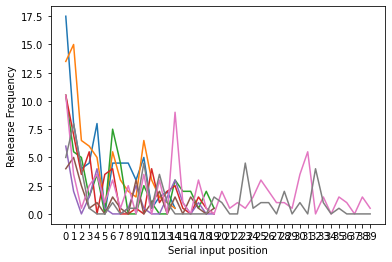

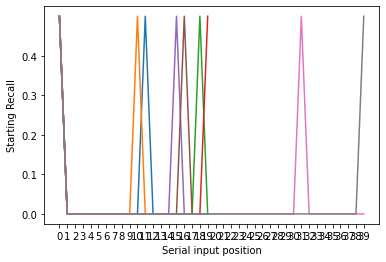

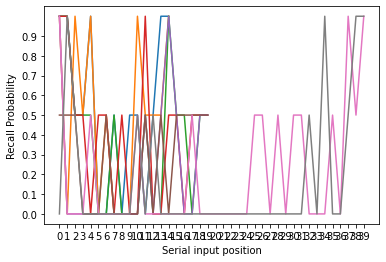

In [5]:
num_lists = 2 #number of lists per agent

#experimental conditions [rehearsal time, list length] from Murdock 1962 
experimental_setup = [[2,15], [2,20], [1,20], [1,40]] 

#to save files to different directory for different numbers of agents
output_path = f'./murdock/agents_{num_agents}/'
if not os.path.isdir(output_path):
    os.mkdir(f'murdock/agents_{num_agents}/')
path = output_path

total_recalled = 0
total_unique = 0

results_dict = {}
for parameter in experimental_setup:
    rh = parameter[0]
    ll = parameter[1]
    
    print("---------------------------------")
    print("Experimental condition:")
    print(f"Number of lists: {num_lists}")
    print(f"Words per list: {ll}")
    print(f"Rehearsal time: {rh} seconds")
    
    for agent in range(num_agents):
        print("------------------------------")
        print(f"Started for agent_{agent}")
        print(f"Words per list: {ll}, rehearsal time: {rh} sec")
        __init__(agent, rehearsal_time=rh, list_length=ll, list_amount=num_lists, path=path)

        try:
            num_recalled, num_unique, results = do_experiment('controls',False,list_amount)
            total_recalled += num_recalled
            total_unique += num_unique
        except ValueError:
            print("\nAgent recalled 0 items.")

    avg_recall = total_recalled // num_agents
    avg_unique = total_unique / num_agents
    

    results_dict[f'Rate: {rh}, Items: {ll}'] = [avg_recall, avg_unique]
    
    print(f"Experimental Condition\nWords per list: {ll}, rehearsal time: {rh} sec")
    print(f"\nAverage number of recalled words ({num_agents} agents): {avg_recall}")
    print(f"Unique: {avg_unique}")

for key, value in results_dict.items():
    print(key)
    print(f'\nAverage number of recalled words: {value[0]}')
    print(f'\nAverage number of unique words: {value[1]}')
    print('-------------------------------------------------------------\n')

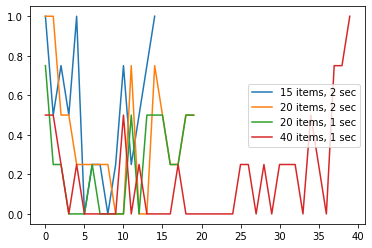

In [6]:
max_list_length = 40
f, ax = plt.subplots(1) #set up plot

for parameter in experimental_setup:
    rh = parameter[0] #rehearsal time
    ll = parameter[1] #words per list

    files = [] #Storing all the relevant files to work on them later
    pattern = f"words_{ll}_lists_{num_lists}_rh_time_{rh}*.txt" # Pattern for matching the filename for data retreival
    for file in os.listdir(path): #Lists all the files and directories within the folder
        #print(file)
        if fnmatch.fnmatch(file, pattern): #matches the above declared patter with the filenames from listdir()
            #print(file)
            files.append(file) #Appends to files to make it available for later use.
    
    # Initializing all the parameters needed for the plots
    idx = [0,1,2]
    xlabel = 'Serial Input Position'
    ylabel = ['Rehearse Frequency','Starting Probability','Recall Probability']
    xticks_len = max_list_length
    rehearse_frequency = []
    recall_probability = []
    first_recall = []
    
    for file in files: #load the result files
        with open(f"{path}/{file}") as f:
            results = json.load(f)
            if results['recall_probability']['data']:
                recall_probability.append(results['recall_probability']['data'])
            else: #if an agent failed to recall anything...
                recall_probability.append([0]*ll)
                
    #calculating avg recall probability per input position across agents            
    avg_recall_probs = [sum(x)/num_agents for x in zip(*recall_probability)]
     
    #plot results
    x = range(ll)
    ax.plot(x, avg_recall_probs, label = f"{ll} items, {rh} sec")    
    
ax.legend()

#("murdock/images/"+subject+"_"+filename, bbox_inches='tight')

##### do_experiment flow:

1. check_and_create_lists
	a. create_lists
	   return word_lists_dict
		i. add_words
            adds to word_lists_dict

2. setup_experiment
    returns window
      model is loaded


3. setup_dm


4. prepare_for_recall


5. close_exp_window


6. analysis
    return result_dict
        contains pstart, pstay, pstop
    prints Avg recall transitions
    
    prints Avg negative thought train length
   

In [9]:
objects = []
with(open("murdock/results_controls.pickle", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break